# Práctico 2

Tareas:
 - Referencia: _Tutorial03 Holt Winters Smoothing.ipynb_ ([acá](https://github.com/DiploDatos/AnalisisSeriesTemporales/blob/master/Tutorial03%20Holt%20Winters%20Smoothing.ipynb))
 - Levantar los datos desde el archivo dataset/demanda.csv. Los mismos fueron extraídos de los datos del informe mensual en http://portalweb.cammesa.com/memnet1/Pages/descargas.aspx
 - Explorar los datos y visualizar descomposición de datos
 - Modelar con Holt Winters Smoothing con diferentes parámetros
 - Visualizar los resultados y evaluar su poder predictivo, comparando ambos modelos

# Time series analysis
# En base a: Tutorial 3: Holt-Winters exponential smoothing


# Ubuntu - run start.sh
```
wget -O get-x13as.sh https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/get-x13as.sh
sh get-x13as.sh
wget -O plotting.py https://github.com/DiploDatos/AnalisisSeriesTemporales/raw/master/plotting.py
```


In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = [15, 10]

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [13]:
# Data:Energía en Argentina

DATA_FILE = 'demanda.csv'

""" $ head demanda.csv
TIPO,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
2013-01-01,4538446.146000001,3319300.732,3276372.4669999997,11134119.345
2013-02-01,3961686.119,2820263.212,3052210.6760000004,9834160.007000001
2013-03-01,3612835.111,2861328.9310000003,3281965.2660000003,9756129.308
2013-04-01,3239380.702,2826797.31,3241156.151,9307334.162999999
2013-05-01,3919668.9960000003,2948663.278,3364493.12,10232825.394
2013-06-01,4409513.94,2873790.5730000003,3077232.68099999,10360537.194
2013-07-01,5088495.112,2956731.611,3110946.67,11156173.393
2013-08-01,4782603.023,2922991.7610000004,3198884.459,10904479.242999999
2013-09-01,4072686.172,2900911.235,3222275.588,10195872.995
""" 

data = pd.read_csv(DATA_FILE, index_col='TIPO', parse_dates=True, dayfirst=True)
data.round(2).tail()


,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2019-03-01,4004709.44,3044854.98,3072063.28,10121627.71
2019-04-01,3652724.52,2892482.73,3029687.89,9574895.14
2019-05-01,4356836.82,2973830.21,3055527.04,10386194.07
2019-06-01,4816838.19,2937048.67,2897618.67,10651505.53
2019-07-01,5704951.02,3288949.87,3035538.42,12029439.31


In [14]:
analyze_field = 'TOTAL'
y = data[analyze_field].copy()
y.index = y.index.to_period(freq='M')
ts = data[analyze_field] # Day indexed series
data.describe().round(2)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,79.00,79.00,79.00,79.00
mean,4551935.29,3113096.42,3187977.02,10853008.74
std,654164.93,206829.98,124659.74,816874.81
min,3239380.70,2809183.13,2897618.67,9307334.16
25%,3990580.45,2948084.14,3109179.19,10223259.40
50%,4470715.12,3070853.24,3199317.20,10706955.32
75%,5092450.46,3270751.91,3275571.56,11476364.98
max,6193110.21,3606989.07,3460879.97,12607552.72


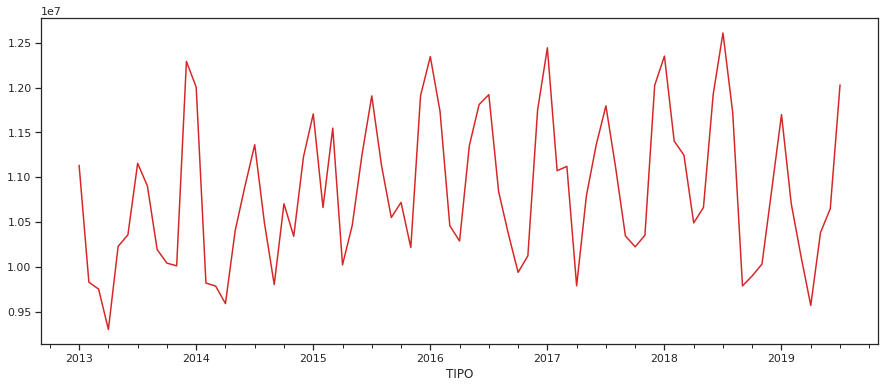

In [16]:
y.plot(color=red, figsize=(15,6))

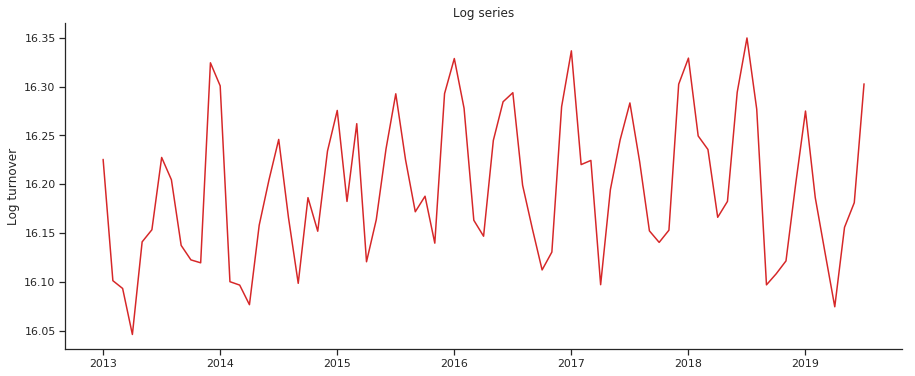

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log ' + analyze_field)
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

In [20]:
# ## Time series decomposition
# 
# We use the X-13 ARIMA-SEATS method for time series decomposition. The X-13 method is a state-of-art time series decomposition approach developed and provided by the [US Census Bureau](https://www.census.gov/srd/www/x13as/) as external software. You need to make the X-13 software available to Python by downloading it from the link and extracting the compressed folder to your computer. The <TT>statsmodels</TT> library has a function that interfaces with this software, and the easiest way to get it to work is to copy the <TT>x13as</TT> executable to the same folder as your notebook.  
# 
# The X-13 is the current version of the X-12-ARIMA method described in the [textbook](https://www.otexts.org/fpp/6/4). The only limitation is that the X-13 software makes calendar effect adjustments based on the US calendar by default, though it is possible to reconfigure it to other calendars. Refer to the [ABS](http://abs.gov.au/websitedbs/d3310114.nsf/4a256353001af3ed4b2562bb00121564/c890aa8e65957397ca256ce10018c9d8) for the seasonal adjustment standards in Australia.  

decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')
# You can use the _dir_ method to check the available output. 
[attr for attr in dir(decomposition) if not attr.startswith('_')]

# For example, if we want to retrieve and plot the seasonally adjusted component, we can do as follows.
decomposition.seasadj.round(2).tail()


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


TIPO
2019-03-01    10252052.84
2019-04-01    10454843.75
2019-05-01    10423639.58
2019-06-01    10217740.23
2019-07-01    10895319.58
Name: seasadj, dtype: float64

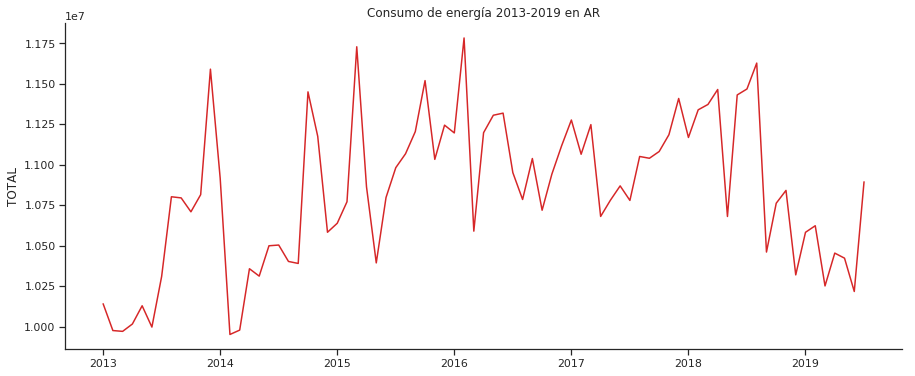

In [23]:
fig, ax= plt.subplots(figsize=(15,6))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel(analyze_field)
ax.set_title('Consumo de energía 2013-2019 en AR')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

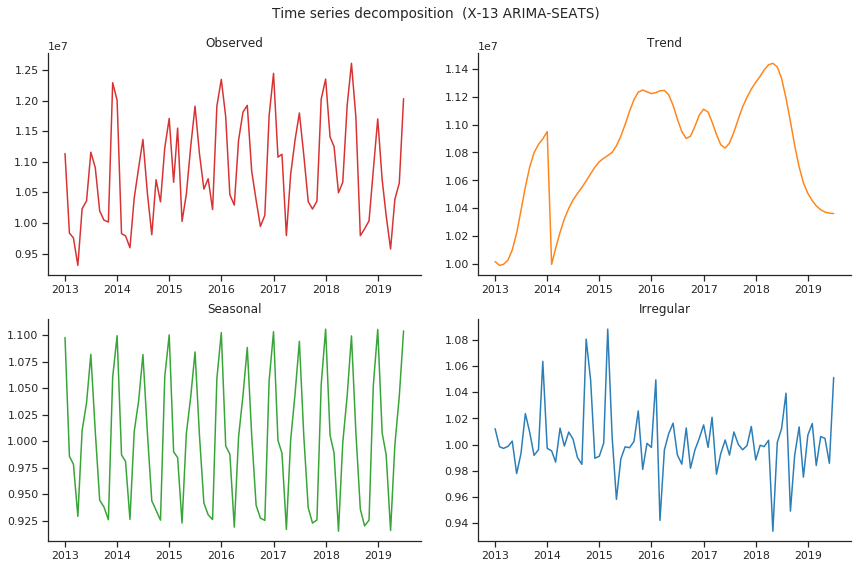

In [24]:
# The _plotting_ module has a convenient function for plotting the components. 
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

In [25]:
# The X-13-ARIMA software generates a very detailed analysis of the time series, which is stored in the <TT>results</TT> attribute. You can view it with the <TT>print(decomposition.results)</TT> command, but due to the length I recommend saving it to a text file and opening it elsewhere. You can do this as follows.  

f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

print(decomposition.results[:300])

  Reading input spec file from /tmp/tmpg5fcp9wa.spc

1

               U. S. Department of Commerce, U. S. Census Bureau

              X-13ARIMA-SEATS monthly seasonal adjustment Method,
                          Release Version 1.1 Build 39


           This software application provides an enhanc


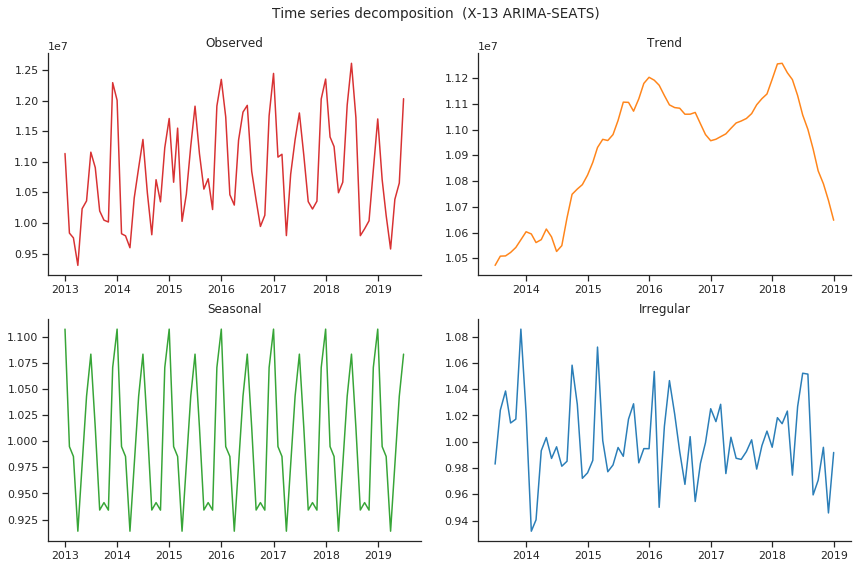

In [26]:
# In case you are not able to work with the X13 decomposition software, a more basic decomposition is available as follows.
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

from plotting import plot_components_basic
plot_components_basic(basic_decomposition);

In [27]:
# ## Trend corrected exponential smoothing
# 
# Before we model and forecast the original series, the next cells demonstrate the application of the trend corrected exponential smoothing method, focusing on the seasonally adjusted series for coherence. 

z=decomposition.seasadj.copy()
z.index=ts.index.to_period(freq='M')

In [28]:
model_sm = sm.tsa.Holt(z).fit()
smoothed_sm = model_sm.fittedvalues
mse_sm = sm.tools.eval_measures.rmse(z,smoothed_sm)
print(' In-sample fit:')
print(' RMSE               {0:.3f}'.format(mse_sm))
model_sm.summary()

 In-sample fit:
 RMSE               373398.951


Dep. Variable:,endog,No. Observations:,79
Model:,Holt,SSE,11014715323221.158
Optimized:,True,AIC,2035.204
Trend:,Additive,BIC,2044.681
Seasonal:,None,AICC,2036.370
Seasonal Periods:,None,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,20:35:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3838743,alpha,True
smoothing_slope,0.000000,beta,True


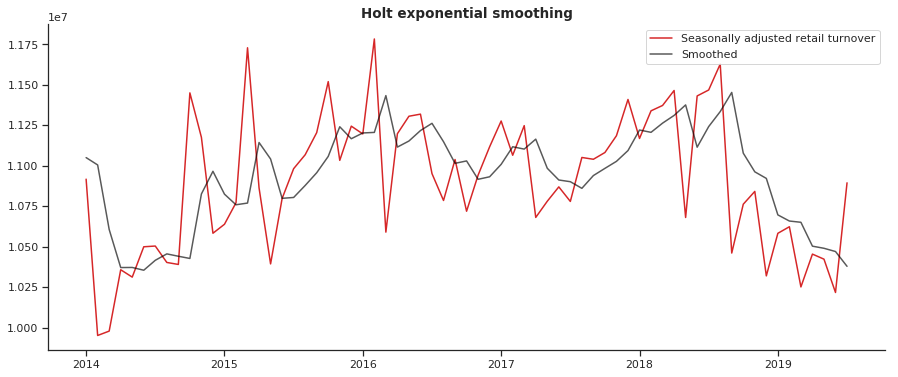

In [30]:
fig, ax= plt.subplots(figsize=(15, 6))

since = '2014'

z[since:].plot(color='#D62728', label='Seasonally adjusted retail turnover')
smoothed_sm['2014':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


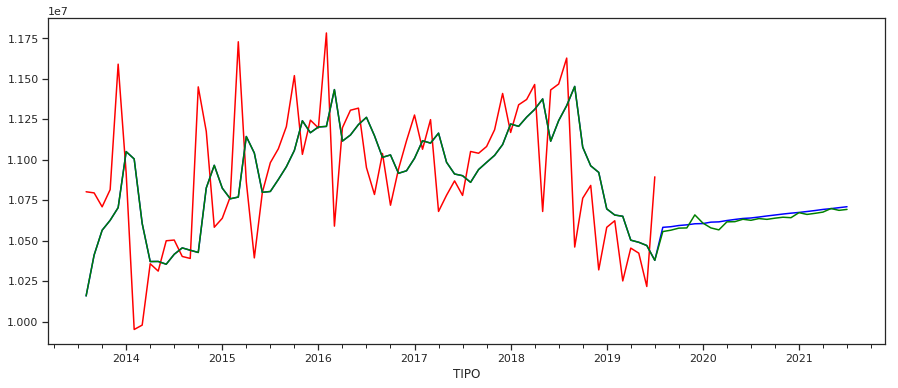

In [32]:
h = 2 * 12 #M
w = h * 3
data = z
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1, h + 1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red', figsize=(15, 6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

In [33]:
# ## Holt-winters exponential smoothing
# 
# We estimate several candidate specifications below.  The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation. 

def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return model_sm.summary()

ahw_sm = sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

hw_summary(ahw_sm)

 In-sample fit:
 RMSE               471015.021


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,17526556823091.641
Optimized:,True,AIC,2095.898
Trend:,Additive,BIC,2133.809
Seasonal:,Additive,AICC,2107.298
Seasonal Periods:,12,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,20:38:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1668078,alpha,True
smoothing_slope,8.3545e-09,beta,True


In [34]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm)

 In-sample fit:
 RMSE               373386.184


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11013962151820.236
Optimized:,True,AIC,2059.198
Trend:,Additive,BIC,2097.109
Seasonal:,Multiplicative,AICC,2070.598
Seasonal Periods:,12,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,20:39:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3555655,alpha,True
smoothing_slope,5.6178e-14,beta,True


In [35]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped)

 In-sample fit:
 RMSE               373992.563


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11049764540008.049
Optimized:,True,AIC,2061.455
Trend:,Additive,BIC,2101.735
Seasonal:,Multiplicative,AICC,2074.336
Seasonal Periods:,12,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,20:39:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3601600,alpha,True
smoothing_slope,0.0526473,beta,True


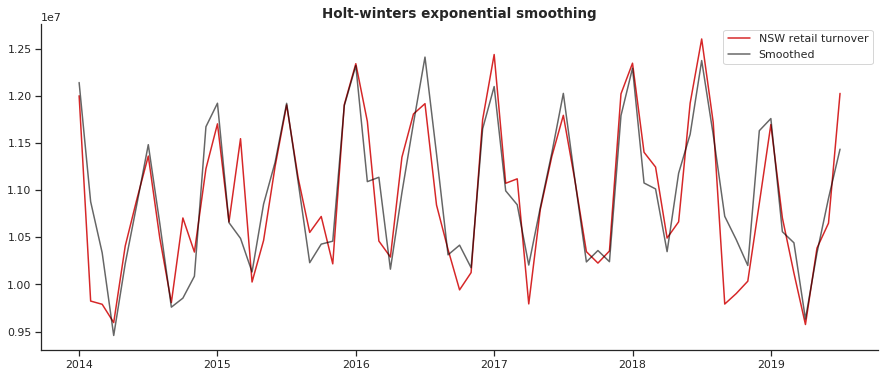

In [37]:
# The smoothed series based on the multiplicative method tracks the original series very closely.

smoothed = pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots(figsize=(15,6))

y[since:].plot(color='#D62728', label='NSW retail turnover')
smoothed[since:].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

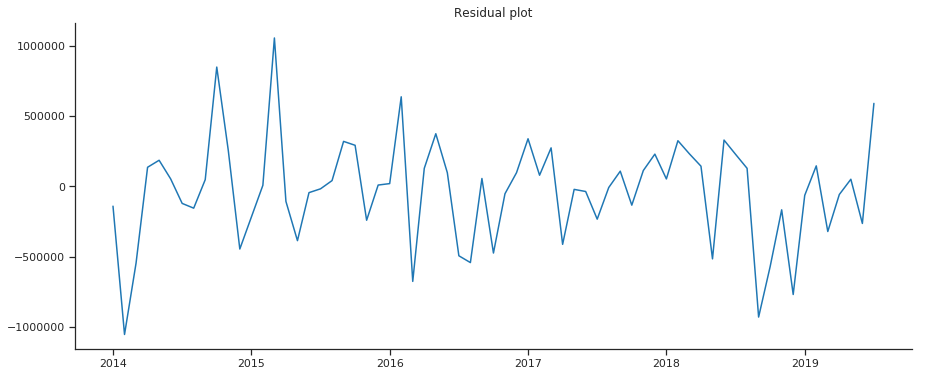

In [39]:
# ## Model diagnostics
# 
# We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

resid = (y-mhw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(15, 6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

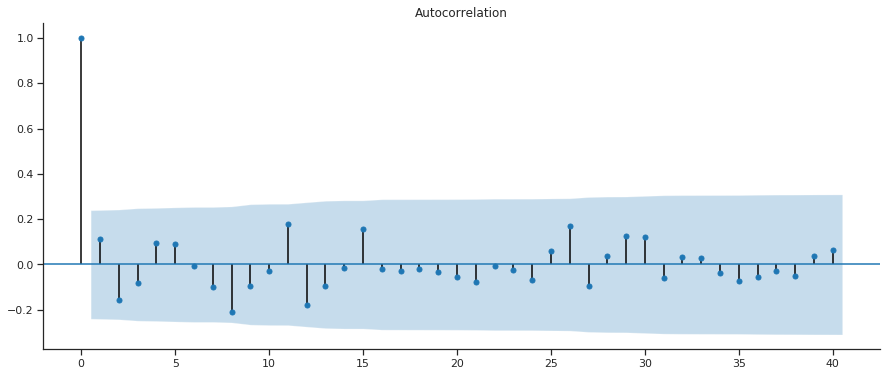

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


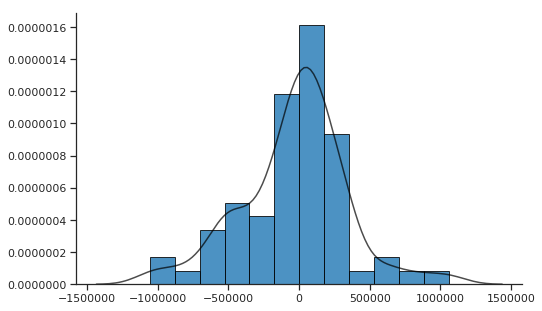

In [41]:
from plotting import histogram

histogram(resid)
plt.show()

In [42]:
# ## Model validation
# 
# The real time forecasting analysis suggests that the log additive Holt Winters model for the log series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform significantly better than a seasonal random walk. 

start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2018-08', 'M')

In [43]:
# Real time forecasting 

validation = y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

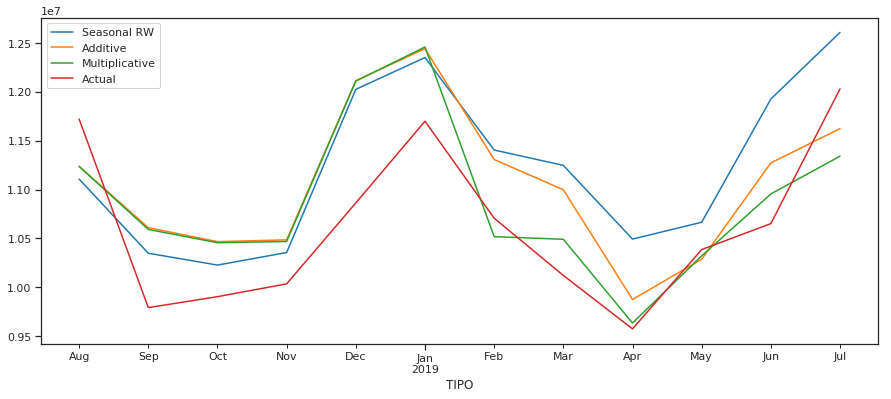

In [46]:
results.plot(figsize=(15, 6));

In [47]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,779964.344,148054.667
Additive,665599.713,151625.898
Multiplicative,594539.876,161498.437


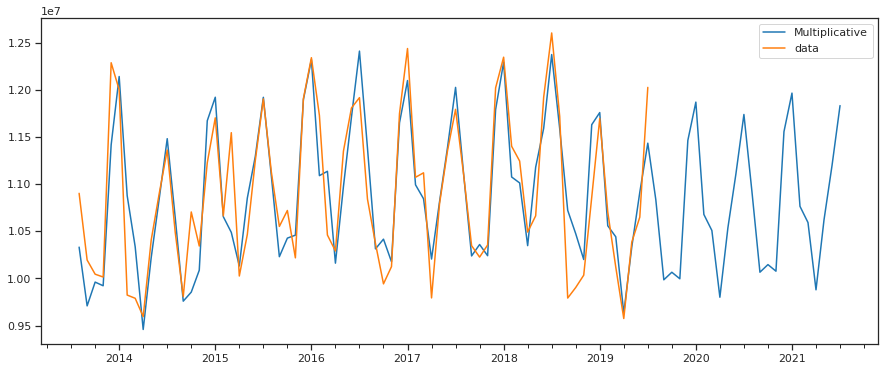

In [48]:
# ## Forecast
# 
# Finally, we generate a two year forecast based on the selected model. 

h = 2 * 12 #M
w = h * 3

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Multiplicative'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['data'] = y

plot[-(w+h):].plot(figsize=(15, 6))